In [21]:
import warnings
from pathlib import Path

import numpy as np
import torch
from rich.progress import track
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassFBetaScore,
    MulticlassPrecision,
    MulticlassRecall,
)

from configs.constants import ACTIVATIONS, CONFIGS, MODELS
from dataset.dataset import ImageDataset
from model import build_model
from utils import utils
from utils.visualize import plot_confusion_matrix

In [2]:
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [3]:
MODEL = "EfficientNet"
CONFIG = "best_config_gpu.yaml"
MODEL_PATH = f"./checkpoints/{MODEL}/best_model.pth"

In [10]:
config_file = f"{Path().resolve()}/configs/{MODEL}/{CONFIG}"
config = CONFIGS[MODEL].from_yaml_file(file=config_file)
class_count = len(config.label_map_legend)
device = utils.get_device()

In [11]:
utils.seed_everything(config.seed)

42

In [12]:
model = build_model(
    class_count=class_count,
    model=MODELS[MODEL],
    hidden_size=config.hidden_size,
    dropout=config.dropout,
    activation=ACTIVATIONS[config.activation],
    trainable_model=config.trainable_model,
)

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.1.1.block.0.0.weight
features.1.1.block.0.1.weight
features.1.1.block.0.1.bias
features.1.1.block.1.fc1.weight
features.1.1.block.1.fc1.bias
features.1.1.block.1.fc2.weight
features.1.1.block.1.fc2.bias
features.1.1.block.2.0.weight
features.1.1.block.2.1.weight
features.1.1.block.2.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.2.fc1.weight
features.2.0.block.2.fc1.bias
features.2.0.block.2.fc2.weight
features.2.0.block.2.fc2.bias
features.2.0.block.3.0.weight
features.2.0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [13]:
test_dataset = ImageDataset(
    config,
    mode="test",
)

test_dataloader = DataLoader(
    batch_size=config.batch_size,
    dataset=test_dataset,
    shuffle=config.shuffle,
    pin_memory=True,
)

Output()

In [14]:
summary(model, input_size=next(iter(test_dataloader))[0].size())

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [80, 3]                   --
├─Sequential: 1-1                                       [80, 1536, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [80, 40, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [80, 40, 112, 112]        (1,080)
│    │    └─BatchNorm2d: 3-2                            [80, 40, 112, 112]        (80)
│    │    └─SiLU: 3-3                                   [80, 40, 112, 112]        --
│    └─Sequential: 2-2                                  [80, 24, 112, 112]        --
│    │    └─MBConv: 3-4                                 [80, 24, 112, 112]        (2,298)
│    │    └─MBConv: 3-5                                 [80, 24, 112, 112]        (1,206)
│    └─Sequential: 2-3                                  [80, 32, 56, 56]          --
│    │    └─MBConv: 3-6                    

In [22]:
f2_score = MulticlassFBetaScore(average="macro", num_classes=class_count, beta=2.0).to(
    device
)
recall = MulticlassRecall(average="macro", num_classes=class_count).to(device)
precision = MulticlassPrecision(average="macro", num_classes=class_count).to(device)
accuracy = MulticlassAccuracy(average="micro", num_classes=class_count).to(device)

In [23]:
test_true_list, test_pred_list = [], []
for img, label in track(test_dataloader):
    with torch.inference_mode():
        if not next(model.parameters()).is_mps or not next(model.parameters()).is_cuda:
            model = model.to(device)

        img, label = img.to(device), label.type(torch.FloatTensor).to(device)
        output = model(img)

        target = torch.argmax(label, dim=1)

        f2_score.update(preds=output, target=target)
        precision.update(preds=output, target=target)
        recall.update(preds=output, target=target)
        accuracy.update(preds=output, target=target)

        test_true_list.append(label.detach().cpu().numpy())
        test_pred_list.append(output.detach().cpu().numpy())

test_metrics = (
    round(f2_score.compute().item(), 4),
    round(accuracy.compute().item(), 4),
    round(recall.compute().item(), 4),
    round(precision.compute().item(), 4),
)

Output()

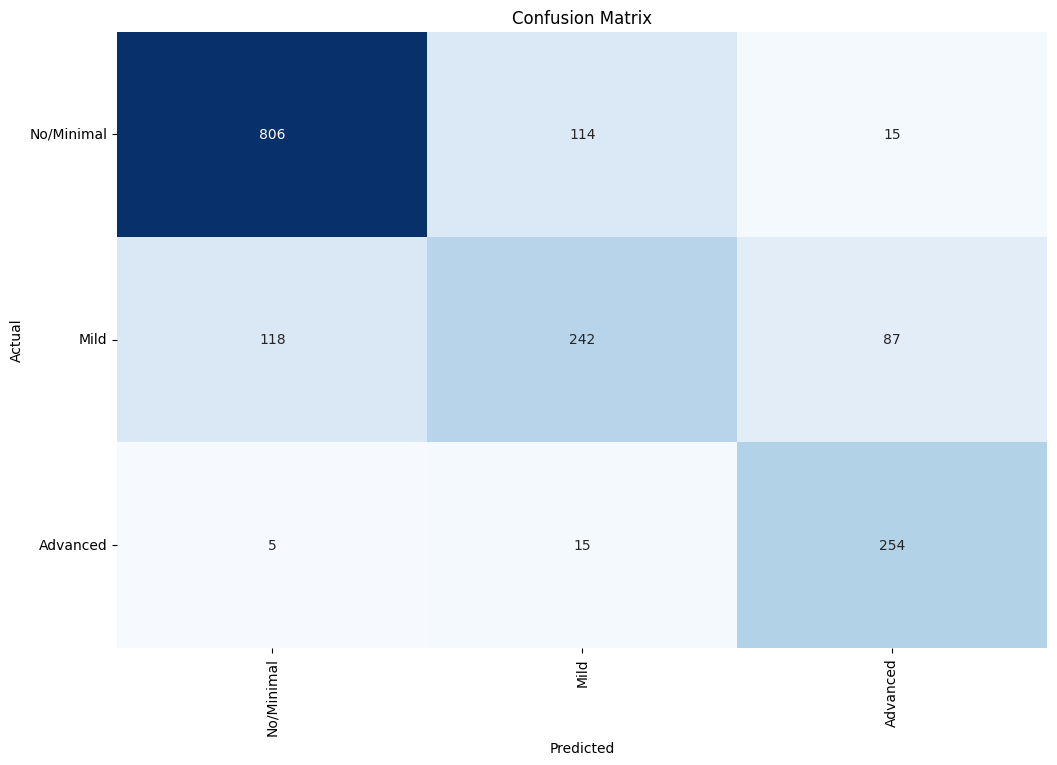

In [24]:
test_true = np.argmax(np.concatenate(test_true_list, axis=0), axis=1)
test_pred = np.argmax(np.concatenate(test_pred_list, axis=0), axis=1)

plot_confusion_matrix(
    test_true,
    test_pred,
    columns=config.label_map_legend.values(),
)

In [25]:
print(f"Test F2 Score: {test_metrics[0]} | Test Accuracy: {test_metrics[1]} | Test Recall: {test_metrics[2]} | Test Precision: {test_metrics[3]}")

Test F2 Score: 0.7661 | Test Accuracy: 0.7862 | Test Recall: 0.7768 | Test Precision: 0.7445
